In [1]:
import torch
import torch.nn as nn
from DNN_ch_tools import *
import random
from torch.utils.data.dataloader import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_squared_error
from math import sqrt
import copy
from physical_ch import *
import matplotlib.pyplot as plt


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(27)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

定义参数

In [2]:
train_length  = 0.8
batch_size    = 100
num_epochs    = 80
step_size     = 20 # 学习率变化周期
gamma         = 0.1 # 学习率更新值
learning_rate = 0.002 # 学习率

# 模型输出迭代初始值
S0            = 500
k_p0          = 0.0001
k_n0          = 0.0001
theta_e0      = 500

数据预处理

In [3]:
# 创建 dataset
dataset_1 = create_dataset(1)
dataset_2 = create_dataset(2)
dataset_3 = create_dataset(3)
dataset_4 = create_dataset(4)

# 将数据的前 train_length 的数据作为训练集 train_set
train_size_1 = int(dataset_1.shape[0] * train_length)
train_size_2 = int(dataset_2.shape[0] * train_length)
train_size_3 = int(dataset_3.shape[0] * train_length)
train_size_4 = int(dataset_4.shape[0] * train_length)
test_size = []
test_size.append(dataset_1.shape[0] * (1 - train_length))
test_size.append(dataset_2.shape[0] * (1 - train_length))
test_size.append(dataset_3.shape[0] * (1 - train_length))
test_size.append(dataset_4.shape[0] * (1 - train_length))

# 分离出训练集和测试集
train_data = []
test_data = []
train_data.append(dataset_1[0:train_size_1])
test_data.append(dataset_1[train_size_1:])
train_data.append(dataset_2[0:train_size_2])
test_data.append(dataset_2[train_size_2:])
train_data.append(dataset_3[0:train_size_3])
test_data.append(dataset_3[train_size_3:])
train_data.append(dataset_4[0:train_size_4])
test_data.append(dataset_4[train_size_4:])

train = np.concatenate((train_data[0], train_data[1], train_data[2], train_data[3]), axis=0)
np.random.shuffle(train)


# 数据归一化
scaler, train_scaled = train_scale(train)
dataset = DataPrepare(train_scaled) # 设置 inputs 和 labels
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True)

PCNN for VRFB Identification

In [4]:
# 定义全连接神经网络类

class DNN(nn.Module):
    def __init__(self, input_dim=5, output_dim=4, hidden_layers=[256, 128, 64, 32, 16, 8]):
        super(DNN, self).__init__()
        
        # 定义隐藏层
        self.hidden_layers = nn.ModuleList()
        layer_sizes = [input_dim] + hidden_layers
        for i in range(len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU())  # 使用ReLU作为激活函数

        # 定义输出层
        self.output1_layer = nn.Linear(hidden_layers[-1], output_dim)
        self.sigmod = nn.Sigmoid()
        # self.output2_layer = nn.Linear(output_dim, 1)

    def forward(self, x):
        for linear in self.hidden_layers:
            x = linear(x)
        out1 = self.output1_layer(self.sigmod(x))
        # out2 = self.output2_layer(out1)
        # return out1, out2
        return out1


# 创建模型实例
model = DNN().to(device)

# 定义损失函数和优化器
loss_function = nn.MSELoss()
loss_function = loss_function.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam 优化器
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

DNN 训练

In [5]:
# 训练模型
min_epochs = 10
best_model = None
min_loss = 0.2

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 5)


        # 梯度清零
        optimizer.zero_grad()
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        # 前向传播
        preds = model(inputs)

        # 计算损失
        S = preds[:, 0]
        k_p = preds[:, 1]
        k_n = preds[:, 2]
        theta_e = preds[:, 3]
        S = S0 * torch.exp(S).cpu()
        k_p = k_p0 * torch.exp(k_p).cpu()
        k_n = k_n0 * torch.exp(k_n).cpu()
        theta_e = theta_e0 * torch.exp(theta_e).cpu()
        T, I, SoC, Q, C_V0, U = invert_scale(scaler, inputs.view(-1, 5).cpu().numpy(),
                                                labels.view(-1, 1).cpu().detach().numpy())
        C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op = get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0)
        e_con = E_con(T, I, Q, C_2, C_3, C_4, C_5)
        e_act = E_act(T, I, S, k_p, k_n, C_2, C_3, C_4, C_5)
        e_ohm = E_ohm(theta_e, T, I)
        e_ocv = E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op)
        e_cell = e_con + e_act + e_ohm + e_ocv
        
        loss = loss_function(e_cell, U)
        train_loss.append(loss.cpu().item())

        # 更新梯度
        loss.backward()

        # 优化参数
        optimizer.step()  # 更新每个网络的权重

    scheduler.step()  # 调整学习率

    if epoch > min_epochs and np.mean(train_loss) < min_loss:
        min_loss = np.mean(train_loss)
        best_model = copy.deepcopy(model)
        best_S = S
        best_k_p = k_p
        best_k_n = k_n
        best_theta_e = theta_e
    
    
    if epoch % 10 == 0:
        print('epoch {} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))
    

torch.save(best_model, f'./result/DNN_ch_model.pth')

epoch 0 train_loss 0.00771015
epoch 10 train_loss 0.00070315
epoch 20 train_loss 0.00069580
epoch 30 train_loss 0.00069564
epoch 40 train_loss 0.00069540
epoch 50 train_loss 0.00069513
epoch 60 train_loss 0.00069508
epoch 70 train_loss 0.00069506


DNN 测试

Forecasting Testing Data
S k_p k_n theta_e: 93.12120056152344 , 1.1124701813969295e-05 , 4.769133010995574e-05 , 43.685752868652344
Test RMSE: 0.01680436


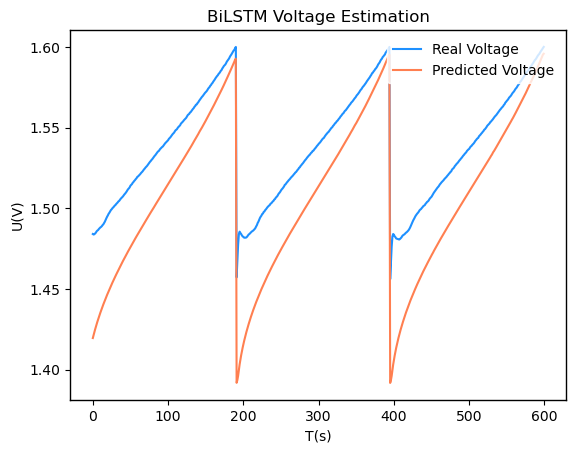

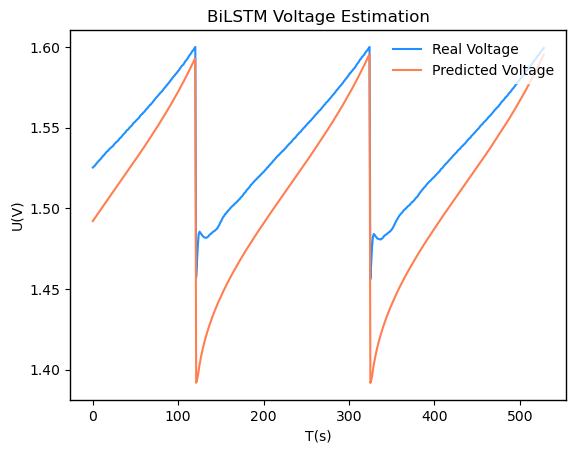

In [9]:
# 测试模型
test_num = 4 # 测试数据集选择
scaler, test_scaled = test_scale(test_data[test_num-1])
best_S = torch.empty(batch_size)
best_k_n = torch.empty(batch_size)
best_k_p = torch.empty(batch_size)
best_theta_e = torch.empty(batch_size)

with torch.no_grad():
    model = torch.load("./result/DNN_ch_model.pth")
    # print(model)
    
    # 预测测试数据
    print('Forecasting Testing Data')
    test_dataset = DataPrepare(test_scaled) # 分离 inputs 和 labels
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # 加载数据
    for i, data in enumerate(test_loader, 0):
        # make one-step forecast
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 5)

        # preds 为预测值
        preds = model(inputs)
        
        S = preds[:, 0]
        k_p = preds[:, 1]
        k_n = preds[:, 2]
        theta_e = preds[:, 3]
        S = S0 * torch.exp(S).cpu()
        k_p = k_p0 * torch.exp(k_p).cpu()
        k_n = k_n0 * torch.exp(k_n).cpu()
        theta_e = theta_e0 * torch.exp(theta_e).cpu()
        T, I, SoC, Q, C_V0, U = invert_scale(scaler, inputs.view(-1, 5).cpu().numpy(),
                                                labels.view(-1, 1).cpu().detach().numpy())
        C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op = get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0)
        e_con = E_con(T, I, Q, C_2, C_3, C_4, C_5)
        e_act = E_act(T, I, S, k_p, k_n, C_2, C_3, C_4, C_5)
        e_ohm = E_ohm(theta_e, T, I)
        e_ocv = E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op)
        e_cell = e_con + e_act + e_ohm + e_ocv
        
        loss = loss_function(e_cell, U)

        if i == 0:
            min_loss = loss
            best_S = S
            best_k_p = k_p
            best_k_n = k_n
            best_theta_e = theta_e


        if i > 0:
            if loss < min_loss:
                min_loss = loss
                best_S = S
                best_k_p = k_p
                best_k_n = k_n
                best_theta_e = theta_e
    

    best_S = best_S.mean().item()
    best_k_p = best_k_p.mean().item()
    best_k_n = best_k_n.mean().item()
    best_theta_e = best_theta_e.mean().item()
    print('S k_p k_n theta_e:', best_S, ',', best_k_p, ',', best_k_n, ',', best_theta_e)
    
    best_S = torch.from_numpy(np.array([best_S]))
    best_k_p = torch.from_numpy(np.array([best_k_p]))
    best_k_n = torch.from_numpy(np.array([best_k_n]))
    best_theta_e = torch.from_numpy(np.array([best_theta_e]))
    T = torch.from_numpy(test_data[test_num-1][:,0])
    I = torch.from_numpy(test_data[test_num-1][:,1])
    SoC = torch.from_numpy(test_data[test_num-1][:,2])
    Q = torch.from_numpy(test_data[test_num-1][:,3])
    C_V0 = torch.from_numpy(test_data[test_num-1][:,4])
    U = torch.from_numpy(test_data[test_num-1][:,5])
    C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op = get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0)
    e_con = E_con(T, I, Q, C_2, C_3, C_4, C_5)
    e_act = E_act(T, I, best_S, best_k_p, best_k_n, C_2, C_3, C_4, C_5)
    e_ohm = E_ohm(best_theta_e, T, I)
    e_ocv = E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op)
    e_cell = e_con + e_act + e_ohm + e_ocv

    # RMSE 评价指标
    rmse_test = sqrt(mean_squared_error(np.array(e_cell) / 2, np.array(U) / 2))
    print('Test RMSE: %.8f' % rmse_test)


data_num = len(U)
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(U, c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(e_cell, c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result/Voltage_result_ch{}.png'.format(test_num))
plt.show()

# 绘制单次充放电循环电压输出预测
# 创建横坐标
start_index = [-612, -612, -532, -530, -553,-434]
end_index = [-1, -1, -1, -1, -1, -1]

data_num = len(U[start_index[test_num-1]:end_index[test_num-1]])
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(U[start_index[test_num-1]:end_index[test_num-1]], c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(e_cell[start_index[test_num-1]:end_index[test_num-1]], c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result/onecycle_voltage_ch{}.png'.format(test_num))
plt.show()